<a href="https://colab.research.google.com/github/lakhdariabderrahmane/3D-Heat-Equation-Simulation-Example-for-Partial-Differential-Equations/blob/main/%D9%85%D8%AC%D9%85%D8%B9%D8%A7%D9%84%D9%84%D8%BA%D8%A9%D8%A7%D9%84%D8%B9%D8%B1%D8%A8%D9%8A%D8%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Numerical Method for the 3D Heat Equation**
> A.Lakhdari



One of the well-known partial differential equations in mathematics is the three-dimensional heat equation (3D Heat Equation), which is given by the following mathematical form:

$$
2 u_{x}^2 + 2 u_{y}^2 + 2 u_{z}^2 = u_t, \quad (x,y,z) \in B(0,1) \subset \mathbb{R}^3, \ t>0
$$

with the boundary condition:

$$
u(x,y,z,t) = 0 \quad \text{on} \quad \partial B(0,1)
$$

This is a second-order linear equation used to model the heat distribution inside a three-dimensional sphere of radius one, denoted mathematically by $ B(0,1) $. The unknown function $ u $ represents the temperature values over time $ t $. The boundary condition is chosen so that the temperature is zero at the surface of the sphere. Experimentally, the sphere can be placed inside a cold bath to keep its boundary cool, satisfying the boundary conditions.

Next, we add initial conditions at time $ t=0 $, where a small hot sphere of radius \( 0.2 \) is placed inside the larger sphere, denoted by $ B(0,0.2) $, and we assume:

$$
u(x,y,z,0) =
\begin{cases}
1, & \text{inside the small sphere } B(0,0.2) \\
0, & \text{outside the small sphere}
\end{cases}
$$

This ensures that the small sphere is initially hot, while the rest of the large sphere is cold. Then, a numerical method can be implemented using Python to visualize the heat distribution at the final time.
To be more specific, we use finite differences numerical method to solve the problem.  

We discretize the computational domain using a uniform grid with spacing $dx$ in all three directions. The Laplacian operator is approximated using **central differences**:

$$
\nabla^2 u \approx
\frac{
u_{i+1,j,k} + u_{i-1,j,k} + u_{i,j+1,k} + u_{i,j-1,k} + u_{i,j,k+1} + u_{i,j,k-1} - 6 u_{i,j,k}
}{dx^2}.
$$

This is implemented in Python using a **3D convolution kernel**.

For the time derivative we use **forward Euler (explicit) scheme**:
#### we can make a good one step method (RK4 for example) for more accurancy

$$
\frac{u^{n+1}_{i,j,k} - u^n_{i,j,k}}{dt} \approx \alpha \, (\nabla^2 u)^n_{i,j,k},
$$

which gives the update formula:

$$
u^{n+1}_{i,j,k} = u^n_{i,j,k} + \alpha \, dt \, (\nabla^2 u)^n_{i,j,k}.
$$

Here, $n$ denotes the current time step.

The Dirichlet boundary conditions are applied by forcing:

$$
u_{i,j,k}^{n} = 0 \quad \text{for all grid points outside the sphere.}
$$

For the **explicit 3D scheme**, the time step must satisfy the following **CFL condition**:

$$
dt \leq \frac{dx^2}{2d\alpha} = \frac{dx^2}{6 \alpha}, \quad d=3,
$$

to ensure numerical stability. In the code, a safety factor of 0.1 is used:


$$dt = 0.1 * dx**2 / (6*alpha)$$


This method allows simulating the **diffusion of heat inside a 3D sphere** and is implemented efficiently in Python using **NumPy** and **convolution operations** in the next code.


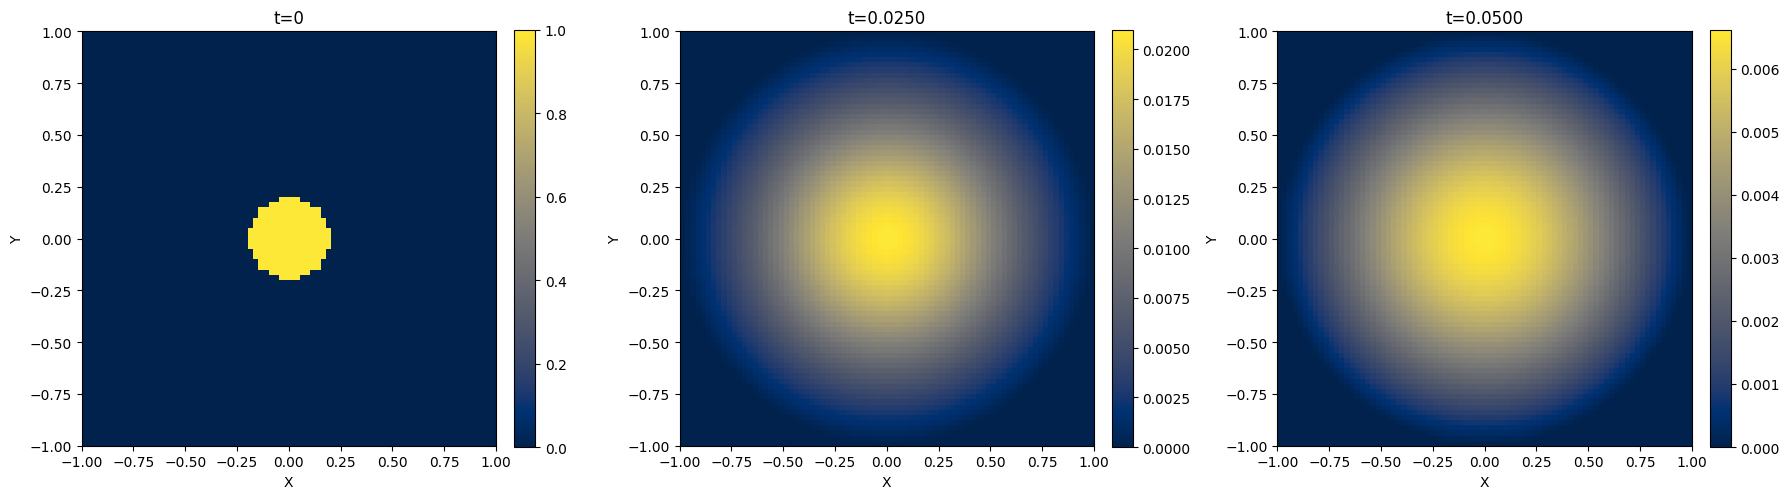

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

# إعداد شبكة
N = 80  # يمكن زيادة أو تقليل حسب دقة المطلوبة
L = 1.0
dx = L / N
alpha = 1.0
dt = 0.1 * dx**2 / (6*alpha)  # لضمان الاستقرار
t_final = 0.05  # الزمن النهائي صغير لتسريع المحاكاة

# شبكة
x = np.linspace(-L, L, N)
y = np.linspace(-L, L, N)
z = np.linspace(-L, L, N)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# الأقنعة
mask_ball = X**2 + Y**2 + Z**2 <= L**2
mask_small = X**2 + Y**2 + Z**2 <= 0.2**2

# مصفوفة الحرارة
u = np.zeros((N,N,N))
u[mask_small] = 1.0

# kernel للاختلافات المركزية 3D
kernel = np.zeros((3,3,3))
kernel[1,1,0] = kernel[1,1,2] = 1
kernel[1,0,1] = kernel[1,2,1] = 1
kernel[0,1,1] = kernel[2,1,1] = 1
kernel[1,1,1] = -6

# حفظ snapshots
snapshots = [u.copy()]

# عدد خطوات الزمن
num_steps = int(t_final/dt)

for n in range(num_steps):
    # Apply finite difference via convolution
    laplace_u = convolve(u, kernel, mode='constant', cval=0.0) / dx**2
    u_new = u + alpha * dt * laplace_u

    # تطبيق شرط الحدود داخل الكرة فقط
    u_new[~mask_ball] = 0
    u = u_new

    # حفظ snapshot عند t_final/2
    if n == num_steps//2:
        snapshots.append(u.copy())

snapshots.append(u.copy())  # اللحظة النهائية

# slice عند z=0
z_index = np.argmin(np.abs(z - 0))

# رسم النتائج
fig, axes = plt.subplots(1, 3, figsize=(18,6))
times_labels = ["t=0", f"t={t_final/2:.4f}", f"t={t_final:.4f}"]

for i, snapshot in enumerate(snapshots):
    im = axes[i].imshow(snapshot[:,:,z_index], extent=[-L,L,-L,L], origin='lower', cmap= 'cividis')
    axes[i].set_title(times_labels[i])
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('Y')
    fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
